In [13]:
# Mount google drive

import json
import os
from google.colab import drive

drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/dfdcDataset/dfdc_train_part_45")



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
# Filter data into real and fake

f = open('metadata.json', "r")

metadata = json.loads(f.read())
metadata = metadata
fakes = []
reals = []
for each in metadata.keys():
  if metadata[each]["label"] == "FAKE":
    fakes.append(each)
  else:
    reals.append(each)
fakes = fakes[:200]
reals = reals[:200]
print(len(fakes), len(reals))

200 200


In [15]:
import cv2
import tensorflow

In [16]:
def extract_frames(video_path, frame_rate):
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    framesInterval = int(fps * frame_rate)
    count = 0
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        if count % framesInterval == 0:
            frames.append(frame)
            break
        count += 1
    video.release()
    return frames

realFrames = {}
fakeFrames = {}
for each in reals:
  realFrames[each] = extract_frames(each, 7)
for each in fakes:
  fakeFrames[each] = extract_frames(each, 7)

# Test for now

In [17]:
# import cv2
# import concurrent.futures


# def extract_frames_wrapper(args):
#     return extract_frames(*args)

# # Function to parallelize frame extraction and organize results into dictionaries
# def extract_and_organize(video_paths, frame_rate):
#     args = [(video_path, frame_rate) for video_path in video_paths]
#     frames_dict = {}
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         video_frames = list(executor.map(extract_frames_wrapper, args))
#         print(video_frames)
#     for video_path, frames in zip(video_paths, video_frames):
#         frames_dict[video_path] = frames
#     return frames_dict

# # Assuming `reals` and `fakes` are lists of video paths for real and fake videos respectively
# frame_rate = 7  # Adjust the frame rate as needed

# # Extract frames for real and fake videos in parallel and organize them into two dictionaries
# realFrames = extract_and_organize(reals, frame_rate)
# fakeFrames = extract_and_organize(fakes, frame_rate)

In [18]:
import numpy as np

def frames_to_dataset(frames_dict, label):
    X = []
    y = []
    for video_path, frames in frames_dict.items():
        for frame in frames:
            frame_resized = cv2.resize(frame, (224, 224))
            X.append(frame_resized)
            y.append(label)
    return np.array(X), np.array(y)

X_real, y_real = frames_to_dataset(realFrames, 0)
X_fake, y_fake = frames_to_dataset(fakeFrames, 1)

X_train = np.concatenate((X_real, X_fake), axis=0)
y_train = np.concatenate((y_real, y_fake), axis=0)

X_train = X_train.astype('float32') / 255.0


In [19]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [20]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



In [21]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=20
)


validation_generator = validation_datagen.flow(X_val, y_val, batch_size=20)


history = model.fit(
    train_generator,
    steps_per_epoch = max(1, len(X_train) // 20),
    epochs=10,
    validation_data=validation_generator,
    validation_steps = max(1, len(X_val) // 20)
)

Epoch 1/10
16/16 [==============================] - 67s 4s/step - loss: 0.5839 - accuracy: 0.7531 - val_loss: 1.5310 - val_accuracy: 0.7250
Epoch 2/10
16/16 [==============================] - 54s 3s/step - loss: 0.5191 - accuracy: 0.8000 - val_loss: 0.6589 - val_accuracy: 0.7250
Epoch 3/10
16/16 [==============================] - 64s 4s/step - loss: 0.5092 - accuracy: 0.7875 - val_loss: 0.7534 - val_accuracy: 0.7250
Epoch 4/10
16/16 [==============================] - 54s 3s/step - loss: 0.5037 - accuracy: 0.7969 - val_loss: 0.9764 - val_accuracy: 0.7250
Epoch 5/10
16/16 [==============================] - 55s 3s/step - loss: 0.4601 - accuracy: 0.8062 - val_loss: 0.7811 - val_accuracy: 0.7250
Epoch 6/10
16/16 [==============================] - 54s 3s/step - loss: 0.4353 - accuracy: 0.8156 - val_loss: 0.7351 - val_accuracy: 0.7250
Epoch 7/10
16/16 [==============================] - 64s 4s/step - loss: 0.4237 - accuracy: 0.8219 - val_loss: 0.7400 - val_accuracy: 0.7250
Epoch 8/10
16/16 [==

3/3 [==============================] - 9s 3s/step - loss: 0.6436 - accuracy: 0.7250
Test Loss: 0.6435745358467102
Test Accuracy: 0.7250000238418579
3/3 [==============================] - 13s 3s/step


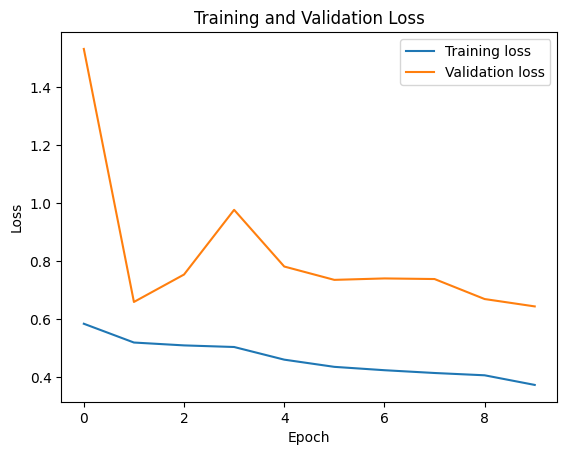

3/3 [==============================] - 11s 3s/step


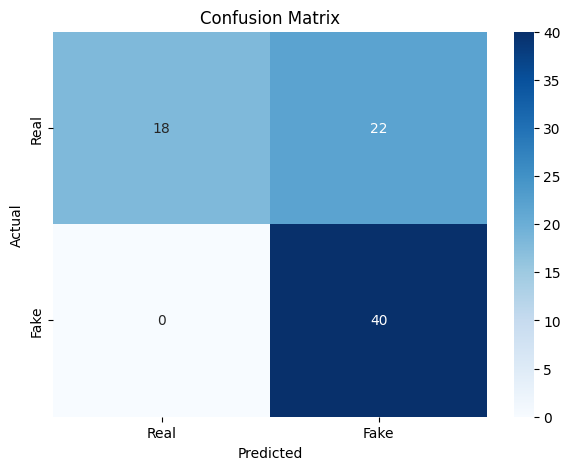

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
test_loss, test_accuracy = model.evaluate(X_val, y_val, batch_size=32)  # Adjust batch size if necessary
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Optional: Predict on test data
predictions = model.predict(X_val, batch_size=32)
predictions = [1 if x > 0.5 else 0 for x in predictions.ravel()]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


y_pred = (model.predict(X_val) > 0.5).astype("int32")

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
model.save('DenseNet121.h5')